<a href="https://colab.research.google.com/github/qml219/CV02_finalproj/blob/main/VietAI_CV02_Quan_Le_Distillation_Polyp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<hr>

* Lớp: Computer Vision and Applications - CV02
* Tổ chức: VietAI


#BƯỚC 01: THIẾT LẬP MÔI TRƯỜNG

### Kiểm tra GPU


In [ ]:
#Trong bài tập này chúng ta cần xử dụng GPU để huấn luyện môn hình (Khuyến nghị các bạn sử dụng V100 để train nhanh hơn).
#Trong thời gian đầu các bạn nên chỉ sử dụng cpu để viết code, chỉ kích hoạt GPU khi đã thực hiện giai đoạn train mô hình.
!nvidia-smi

Sat May 25 10:28:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              47W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!rm -rf polyp_dataset_project10
!pip install patool
!pip install unrar


### Tải tập dữ liệu Polyp - Mount from GG Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
from zipfile import ZipFile
import unrar
import patoolib


def change_dir(func, original_dir):
  os.chdir(original_dir)
  func()
  os.chdir(original_dir)

def extract():
  os.chdir('/content/drive/MyDrive/VietAI_CV02')
  filename = "polyp_dataset_project10.zip"
  extract_path = "/content"


  if not os.path.exists(extract_path + '/' + filename[:-4]):
    patoolib.extract_archive(filename, outdir=extract_path)
  print("Polyp data is extracted at: " + extract_path)

print(os.getcwd())
change_dir(extract, os.getcwd())

INFO patool: Extracting polyp_dataset_project10.zip ...
INFO:patool:Extracting polyp_dataset_project10.zip ...
INFO patool: running /usr/bin/7z x -o/content -- polyp_dataset_project10.zip
INFO:patool:running /usr/bin/7z x -o/content -- polyp_dataset_project10.zip
INFO patool:     with input=''
INFO:patool:    with input=''


/content


INFO patool: ... polyp_dataset_project10.zip extracted to `/content'.
INFO:patool:... polyp_dataset_project10.zip extracted to `/content'.


Polyp data is extracted at: /content


### Cài đặt một số thư viện cần thiết nếu cần

In [ ]:
!pip install celluloid        #Chúng ta cần thư viện này để visualize dữ liện khối 3D ở dạng video

### Khai báo sử dụng một số thư viện cần thiết

In [ ]:
from __future__ import absolute_import, division, print_function
#%matplotlib notebook

import glob
import os
from os import path
import shutil
from pathlib import Path              #Xử lý đường dẫn
import nibabel as nib                 #Xử lý định dạng NIfTI
from tqdm.notebook import tqdm        #Hiện thanh tiến trình
import re                             #Biểu thức chính quy (Regular expression)

import zipfile                        #Giải nén file zip
import json                           #Đọc file json
from copy import deepcopy

import numpy as np                    #Đại số tuyến tính (linear algebra)
import pandas as pd                   #Xử lý dataset, file CSV
import argparse
import random
from scipy import misc
from skimage import draw

from sklearn.model_selection import train_test_split             #Chia tập dữ liệu train & val
from sklearn.metrics import jaccard_score

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim

import torchvision.transforms as transforms
import torchvision
from fastprogress import master_bar, progress_bar

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
from PIL import Image
from IPython.display import HTML
import cv2
import time

#Tăng cường dữ liệu
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

print('Importing... done!')

Importing... done!


### Thiết lập một số các tham số quan trọng để chạy mô hình


In [ ]:
cfg={
  "DIR_IMAGE": "./polyp_dataset_project10/images",
  "TRAIN_JSON": "./polyp_dataset_project10/polyp_train.json",
  "TEST_JSON": "./polyp_dataset_project10/polyp_test.json",
  "VAL_JSON": "./polyp_dataset_project10/polyp_valid.json",

  "IMG_SIZE": 224,

  "NORMALIZATION":True,
  "NORMALIZATION_MEAN": [0.485, 0.456, 0.406],
  "NORMALIZATION_STD": [0.229, 0.224, 0.225],
  "BATCH_SIZE": 64,
  "NUM_WORKER": 8,
  "LEARNING_RATE": 0.0001,
  "MAX_EPOCHS": 20,                              # Số lượng epoch tối đa
  "Optimizer": "ADAM",

  "LR_SCHEDULER": "MultistepLR",           #Có thể chọn các giá trị sau : "ReduceLROnPlateau",  "MultiStepLR", "LinearLR" phụ thuộc vào TODO 1:

    # Drops learning rate by a factor of gamma once the current number of epochs exceeds each milestone - 6, 7, 7
    "MultistepLR": {
      "milestones": [7, 14],
      "gamma": 0.1,
    },
  # END SOLUTION

  # "ReduceLROnPlateau": {
  #   "LEARNING_RATE_SCHEDULE_FACTOR": 0.1,           # Parameter cho reducing learning rate
  #   "LEARNING_RATE_SCHEDULE_PATIENCE": 5,           # Parameter cho reducing learning rate
  # },
}

#BƯỚC 02: TÌM HIỂU VÀ TIỀN XỬ LÝ DỮ LIỆU CHO TẬP DỮ LIỆU POLYP

###Tiền xử lý dữ liệu



In [ ]:
import json
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

In [ ]:
# READ JSON method

os.chdir('/content')
def read_json(filepath):
  with open(filepath, 'r') as f:
    data = json.load(f)
  return data

train_data = read_json(cfg['TRAIN_JSON'])
val_data = read_json(cfg['VAL_JSON'])
test_data = read_json(cfg['TEST_JSON'])

### Visualize một hình và label

In [ ]:
# #Định nghĩa một hàm cho việc hiển thị một slide thông qua id của lung và số thứ tự của slide
# def VisualizeSlice(cfg,lung_id,slide_id):
#   image_path=f"{cfg['DIR_PREPROCESS']}/images/{lung_id}/{slide_id}.npy"
#   mask_path=f"{cfg['DIR_PREPROCESS']}/masks/{lung_id}/{slide_id}.npy"

#   ##### TODO 3: Với image_path, mask_path chứa đường dẫn của slice và mask tương ứng lưu trữ ở dạng npy             ######
#   ##### Hãy viết code hoàn thiện hàm này để có thể hiện thị ảnh slice và ảnh slice có mask phổi dược overlay trên nó######
#   # BEGIN SOLUTION
#   slice = np.load(image_path)
#   mask = np.load(mask_path)
#   # END SOLUTION

#   #Hiển thị image và mask
#   fig=plt.figure(figsize=(2*10,1*10))
#   fig.suptitle(f"Image {lung_id} and slice {slide_id}",fontsize=24)
#   plt.subplot(1,2,1)
#   plt.title("Slice Image")
#   plt.axis('off')
#   plt.imshow(slice, cmap="bone")
#   plt.subplot(1,2,2)
#   plt.title("Mask")
#   plt.axis('off')
#   mask_ = np.ma.masked_where(mask==0, mask)
#   plt.imshow(slice, cmap="bone")
#   plt.imshow(mask_, cmap="autumn")
#   plt.show()

# #Hiển thị lung_001 và slice thứ 210 của nó.
# VisualizeSlice(cfg,'lung_001',210)

#BƯỚC 03: CHUẨN BỊ DATALOADER CHO TRAIN, VAL, TEST DATA

In [ ]:
class PolypDataset(Dataset):
    def __init__(self, data, cfg, mode="train", transform=None, augment_params=None):
        self.data = data['images']
        self.cfg = cfg
        self.mode = mode
        self.transform = transform
        self.class_to_idx = {"pedunculated": 0, "sessile": 1}

        # Default augmentation parameters using albumentations
        if augment_params is None:
            self.augment_params = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomCrop(height=cfg['IMG_SIZE'], width=cfg['IMG_SIZE'], p=0.5),
                A.GaussianBlur(blur_limit=(3, 7), p=0.2),
                A.Affine(scale=(0.8, 1.2), translate_percent=(-0.2, 0.2), rotate=(-25, 25), shear=(-15, 15), p=0.5),
            ])
        else:
            self.augment_params = augment_params

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Get image path and label
        img_path = self.data[index]['image_path']
        img_label = self.class_to_idx[self.data[index]['type']]


        # Load image
        img = np.array(Image.open(img_path).convert('RGB'))

        # # Apply augmentations
        # if self.mode == 'train' and self.augment_params is not None:
        #     img = self.augment_params(image=img)['image']

        # Apply transformations
        if self.transform:
            img = self.transform(image=img)['image']

        one_hot_labels = torch.zeros(2)
        one_hot_labels[img_label] = 1

        return img, one_hot_labels

In [ ]:
#Tạo dataloader cho Train-Val-Test

# Define transformations
# normalization
# resize to fit model input dimensionality
preprocess = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(cfg['IMG_SIZE'], cfg['IMG_SIZE']),
    A.Normalize(mean=cfg['NORMALIZATION_MEAN'], std=cfg['NORMALIZATION_STD']),
    ToTensorV2()
])

train_dataset = PolypDataset(train_data, cfg, mode="train", transform=preprocess)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=cfg['BATCH_SIZE'], shuffle=True, num_workers=cfg["NUM_WORKER"], pin_memory=True)
print(f"-Number of train data: {len(train_dataset)}")

val_dataset = PolypDataset(val_data, cfg, mode="val", transform=preprocess)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=cfg['BATCH_SIZE'], shuffle=False, num_workers=cfg["NUM_WORKER"], pin_memory=True)
print(f"-Number of val data: {len(val_dataset)}")

test_dataset = PolypDataset(test_data, cfg, mode="test", transform=preprocess)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=cfg['BATCH_SIZE'], shuffle=False, num_workers=cfg["NUM_WORKER"], pin_memory=True)
print(f"-Number of test data: {len(test_dataset)}")


-Number of train data: 1200
-Number of val data: 400
-Number of test data: 400


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
count_zero = 0
count_one = 0

os.chdir('/content/polyp_dataset_project10')
for batch, (images, labels) in enumerate(train_dataloader):
  class_labels = torch.argmax(labels, dim=1)
  count_zero += (class_labels == 0).sum().item()
count_one = len(train_dataset) - count_zero
print(count_one, count_zero)

1065 135


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
def get_balanced_sampler(dataset, train_ratio=1.0):

  labels = []
  balanced_indices = []

  for index in range(len(dataset)):
    img, label = dataset.__getitem__(index)
    label = torch.where(label == 1)[0].item()
    labels.append(label)

  labels = np.array(labels)
  classes = np.unique(labels)
  class_indices = [np.where(labels == c)[0] for c in classes]

  for class_idx in class_indices:
    n_samples = int(len(class_idx) * train_ratio)
    sampled_indices = np.random.choice(class_idx, n_samples, replace=False)
    balanced_indices.extend(sampled_indices)

  return SubsetRandomSampler(balanced_indices)

In [ ]:
# ResNet50 from torchvision.models
from torchvision import models

#BƯỚC 05: ĐỊNH NGHĨA LOSS FUNCTION, METRICS, OPTIMIZER, SCHEDULE

In [ ]:
loss_criteria = nn.CrossEntropyLoss()
optimizer_adam = lambda model: optim.Adam(model.parameters())

#BƯỚC 06: ĐỊNH NGHĨA CÁC BƯỚC CƠ SỞ ĐỂ TRAIN, VALID VÀ TEST

In [ ]:
#Train phase
def train_epoch(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb, train_ratio=1.0):

    # Chuyển model sang training mode
    model.train()
    training_loss = 0 # Lưu trữ tổng của training losses
    len_training_set = 0

    if train_ratio < 1.0:
      sampler = get_balanced_sampler(train_dataloader.dataset, train_ratio)
      train_dataloader = DataLoader(train_dataloader.dataset,
                                        batch_size=train_dataloader.batch_size,
                                        sampler=sampler,
                                        num_workers=train_dataloader.num_workers,
                                        pin_memory=True)

    # print(total_training)

    images, labels, loss = None, None, 0.0

    # Với mỗi batch
    for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):


        # Di chuyển images, masks đến device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Xóa gradient trước
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)


        loss = loss_criteria(pred, labels)

        # Back propagation
        loss.backward()

        # Cập nhât parameters
        optimizer.step()

        # Cập nhât training loss sau mỗi batch
        training_loss += loss.item() * images.size(0)

        mb.child.comment = f'Training loss {training_loss/(batch+1)}'

        len_training_set += images.size(0)

    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # Trả lại training loss
    return training_loss / len_training_set

In [ ]:
#Evaluation phase
def evaluation_epoch(epoch, model, val_dataloader, device, loss_criteria, mb):

    # Chuyển model sang training mode
    model.eval()

    val_loss = 0                                   # Tổng loss của model trên validation set
    batch_corrects = 0
    len_validation_set = 0

    with torch.no_grad(): # Tắt gradient
        # Với mỗi batch
        for step, (images, labels) in enumerate(progress_bar(val_dataloader, parent=mb)):
            # Di chuyển images, masks đến device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Feed forward the model
            pred = model(images)
            loss = loss_criteria(pred, labels)

            # Count correct classfication
            # CrossEntropyLoss
            _, pred = torch.max(pred, 1)
            # pred = (pred > 0.5).float()
            batch_corrects += torch.sum(pred == torch.argmax(labels, dim=1))

            len_validation_set += images.size(0)

            # Cập nhât validation loss sau mỗi batch
            val_loss += loss.item() * images.size(0)
            mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    # Xóa bộ nhớ
    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # Trả lại validation loss và metric score accuracy
    return val_loss / len_validation_set, batch_corrects.cpu() / len_validation_set

In [ ]:
import torch

def full_training(model, save_path, max_epochs, train_dataloader, val_dataloader, optimizer, loss_criteria, lr_scheduler, device, train_ratio=1.0):
    best_acc = 0
    training_losses = []
    validation_losses = []
    validation_score = []

    # Config progress bar
    mb = master_bar(range(max_epochs))
    mb.names = ['Training loss', 'Validation loss', 'Validation Accuracy']
    x = []

    # Training mỗi epoch
    for epoch in mb:
        mb.main_bar.comment = f'Best accuracy score: {best_acc}'
        x.append(epoch)

        # Train
        train_loss = train_epoch(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb, train_ratio)
        mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
        training_losses.append(train_loss)

        # Clear cache after each training epoch
        torch.cuda.empty_cache()

        # Evaluate
        val_loss, new_accuracy = evaluation_epoch(epoch, model, val_dataloader, device, loss_criteria, mb)
        mb.write('Finish validation epoch {} with loss {:.4f} and score {:.4f}'.format(epoch, val_loss, new_accuracy))
        validation_losses.append(val_loss)
        validation_score.append(new_accuracy)

        # Clear cache after each evaluation epoch
        torch.cuda.empty_cache()

        # Cập nhật learning rate
        lr_scheduler.step(val_loss)

        # Cập nhật training chart
        mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0, max_epochs], [0, 1])

        # Lưu model
        if best_acc < new_accuracy:
            mb.write(f"Improve validation accuracy from {best_acc} to {new_accuracy}")
            best_acc = new_accuracy

            # Lưu model: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save(model.state_dict(), save_path)

        # Delete unnecessary variables to save GPU RAM
        del train_loss, val_loss, new_accuracy

    # Clear cache one last time
    torch.cuda.empty_cache()


In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#BƯỚC 7: HUẤN LUYỆN MÔ HÌNH

In [ ]:
class CustomResNet50(nn.Module):
  def __init__(self, num_classes=2):
    super().__init__()
    self.model = models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V2")
    self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

  def forward(self, input):
    return self.model(input)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed(42)
model = CustomResNet50().to(device)

In [ ]:
print_num_params = lambda model: print(f'Number of trainable parameters: {sum((p.numel() for p in model.parameters() if p.requires_grad is True))}')
print_num_params(model)

Number of trainable parameters: 23512130


/content/polyp_dataset_project10


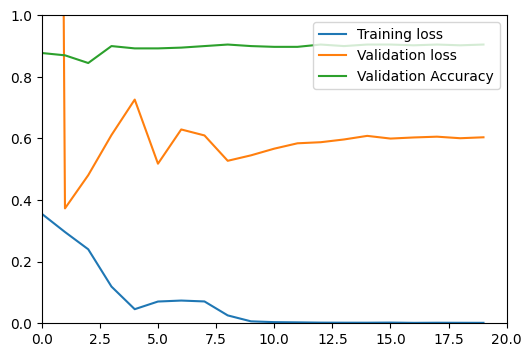

In [ ]:
save_path = "../drive/MyDrive/VietAI_CV02/resnet.pth"

set_seed(42)
os.chdir('/content')
os.chdir('./polyp_dataset_project10')
print(os.getcwd())
model_optimizer = optimizer_adam(model)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, mode='min', factor=0.1, patience=5)
full_training(model, save_path,cfg['MAX_EPOCHS'], train_dataloader, val_dataloader, model_optimizer, loss_criteria, lr_scheduler, device)
os.chdir('/content')

# EfficientNet B1

In [ ]:
class CustomEfficientNet_B1(nn.Module):
  def __init__(self, num_classes=2):
    super().__init__()
    self.model = models.efficientnet_b4(weights="EfficientNet_B4_Weights.IMAGENET1K_V1")
    self.model.classifier = nn.Sequential(nn.Dropout(self.model.classifier[0].p, inplace=True),
                                          nn.Linear(self.model.classifier[1].in_features, num_classes))

  def forward(self, input):
    return self.model(input)

In [ ]:
set_seed(42)
model_2 = CustomEfficientNet_B1().to(device)
print(f'Number of trainable parameters: {sum((layer.numel() for layer in model_2.parameters() if layer.requires_grad))} parameters')

Number of trainable parameters: 17552202 parameters


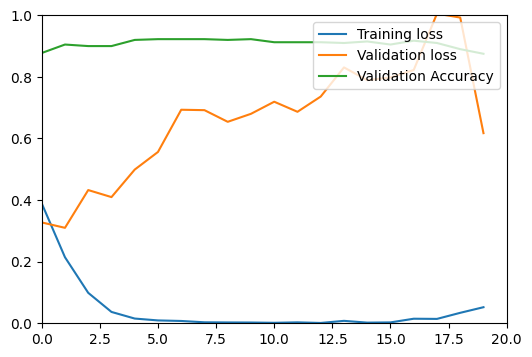

In [ ]:
save_path= '../drive/MyDrive/VietAI_CV02/efficientnet.pth'
set_seed(42)
os.chdir('/content')
os.chdir('./polyp_dataset_project10')
model_2_optimizer = optimizer_adam(model_2)
full_training(model_2, save_path, cfg['MAX_EPOCHS'], train_dataloader, val_dataloader, model_2_optimizer, loss_criteria, lr_scheduler, device)
os.chdir('/content')

In [ ]:
# Testing Phase

In [ ]:
def testing_phase(model, data_loader):

  model.eval() # Set mode to evaluation to disable stochastic operations like Dropouts and Batch Normalization

  corrects = 0
  len_test = 0

  for batch, (images, labels) in enumerate(data_loader):

    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)

    preds = torch.argmax(outputs, dim=1)
    labels = torch.argmax(labels, dim=1)
    corrects += (preds == labels).sum().item()
    len_test += images.size(0)

  del images, labels, outputs, preds

  return corrects / len_test

In [ ]:
def testing_phase_single_class(model, data_loader, target_class_idx):

  model.eval() # Set mode to evaluation to disable stochastic operations like Dropouts and Batch Normalization

  corrects = 0
  len_test = 0

  for batch, (images, labels) in enumerate(data_loader):

    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)

    preds = torch.argmax(outputs, dim=1)
    labels = torch.argmax(labels, dim=1)
    corrects += torch.where((preds == labels) & (labels == target_class_idx), 1.0, 0.0).sum().item()
    len_test += (labels == target_class_idx).sum().item()

  del images, labels, outputs, preds

  return corrects / len_test

In [ ]:
  if torch.cuda.is_available(): torch.cuda.empty_cache()

In [ ]:
os.chdir('/content')

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(42)
model = CustomResNet50().to(device) # Create an instance of ResNet50
model_2 = CustomEfficientNet_B1().to(device)  # Create an instance of EfficientNet-B0

best_resnet_dict = torch.load('./drive/MyDrive/VietAI_CV02/resnet.pth')
best_efficientnet_b0_dict = torch.load('./drive/MyDrive/VietAI_CV02/efficientnet.pth')

model.load_state_dict(best_resnet_dict)
model_2.load_state_dict(best_efficientnet_b0_dict)

<All keys matched successfully>

In [ ]:
os.chdir('/content/polyp_dataset_project10')
print(f'Testing Accuracy on class 0 - Resnet50: {testing_phase_single_class(model, test_dataloader, target_class_idx=0):.4f}%')
print(f'Testing Accuracy on class 0- EfficientNet B4: {testing_phase_single_class(model_2, test_dataloader, target_class_idx=0):.4f}%')

print(f'Testing Accuracy on class 1 - Resnet50: {testing_phase_single_class(model, test_dataloader, target_class_idx=1):.4f}%')
print(f'Testing Accuracy on class 1- EfficientNet B4: {testing_phase_single_class(model_2, test_dataloader, target_class_idx=1):.4f}%')

print(f'Testing Accuracy - Resnet50: {testing_phase(model, test_dataloader):.4f}%')
print(f'Testing Accuracy - EfficientNet B4: {testing_phase(model_2, test_dataloader):.4f}%')

Testing Accuracy on class 0 - Resnet50: 0.4524%
Testing Accuracy on class 0- EfficientNet B4: 0.3095%
Testing Accuracy on class 1 - Resnet50: 0.9749%
Testing Accuracy on class 1- EfficientNet B4: 0.9804%
Testing Accuracy - Resnet50: 0.9200%
Testing Accuracy - EfficientNet B4: 0.9100%


# Distilling MobileNet with EfficientNet B4

In [ ]:
class CustomMobileNet(nn.Module):
  def __init__(self, num_classes=2):
    super().__init__()
    self.model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
    self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

  def forward(self, inputs):
    return self.model(inputs)

In [ ]:
set_seed(42)
model_3 = CustomMobileNet()
print(f'Number of trainable parameters: {sum((layer.numel() for layer in model_3.parameters() if layer.requires_grad))} parameters')
print(cfg['BATCH_SIZE'])

Number of trainable parameters: 2226434 parameters
64


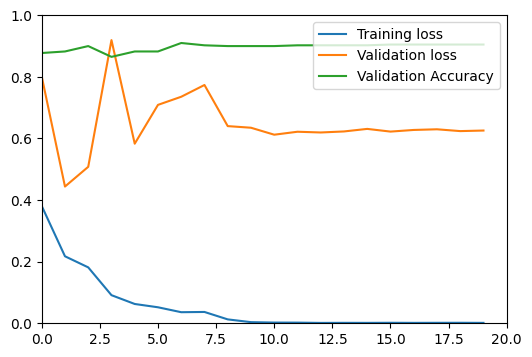

In [ ]:
# Train student network - MobileNet V2 - without teacher
os.chdir('/content')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_3.to(device)
save_path = ('../drive/MyDrive/VietAI_CV02/raw_mobilenet.pth')
set_seed(42)
os.chdir('./polyp_dataset_project10')
model_3_optimizer = optimizer_adam(model_3)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(model_3_optimizer, mode='min', factor=0.1, patience=5)
full_training(model_3, save_path, cfg["MAX_EPOCHS"], train_dataloader, val_dataloader, model_3_optimizer, loss_criteria, lr_scheduler, device)

In [ ]:
os.chdir('/content')
set_seed(42)
model_3 = CustomMobileNet().to(device)

best_raw_mobilenet_state_dict = torch.load('./drive/MyDrive/VietAI_CV02/raw_mobilenet.pth')
model_3.load_state_dict(best_raw_mobilenet_state_dict)

<All keys matched successfully>

In [ ]:
# Test MobileNet V2 without teacher
os.chdir('/content/polyp_dataset_project10')
print(f'Testing Accuracy - Raw MobileNet_V2: {testing_phase_single_class(model_3, test_dataloader, target_class_idx=0):.4f}%')

Testing Accuracy - Raw MobileNet_V2: 0.3571%


In [ ]:
class CustomResNet18(nn.Module):
  def __init__(self, num_classes=2):
    super().__init__()
    self.model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
    self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

  def forward(self, input):
    return self.model(input)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed(42)
raw_resnet18 = CustomResNet18().to(device)
# print(raw_resnet18)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


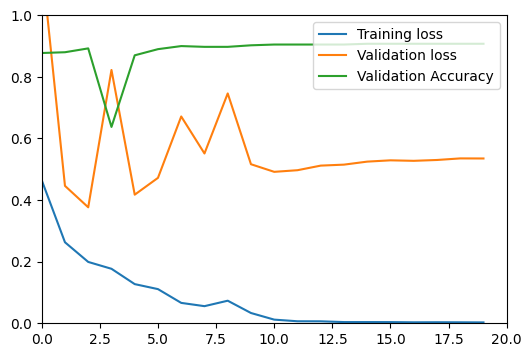

In [ ]:
#Train student network - Resnet18 without teacher
os.chdir('/content')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed(42)
raw_resnet18 = CustomResNet18().to(device)
save_path = ('../drive/MyDrive/VietAI_CV02/raw_resnet18.pth')

os.chdir('./polyp_dataset_project10')
raw_resnet18_optimizer = optimizer_adam(raw_resnet18)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(raw_resnet18_optimizer, mode='min', factor=0.1, patience=5)
full_training(raw_resnet18, save_path, cfg["MAX_EPOCHS"], train_dataloader, val_dataloader, raw_resnet18_optimizer, loss_criteria, lr_scheduler, device)


In [ ]:
os.chdir('/content')
set_seed(42)
raw_resnet18 = CustomResNet18().to(device)

best_raw_resnet18_state_dict = torch.load('./drive/MyDrive/VietAI_CV02/raw_resnet18.pth')
raw_resnet18.load_state_dict(best_raw_resnet18_state_dict)

<All keys matched successfully>

In [ ]:
# Test ResNet18 without teacher
os.chdir('/content/polyp_dataset_project10')
print(f'Testing Accuracy - Raw Resnet18: {testing_phase_single_class(raw_resnet18, test_dataloader, target_class_idx=0):.4f}')

Testing Accuracy - Raw Resnet18: 0.3095


In [ ]:
def train_distilled_epoch(epoch, teacher, student, train_dataloader, T, soft_loss_weight, optimizer, hard_loss_criteria=nn.CrossEntropyLoss(), device=None, mb=None, train_ratio=1.0):
  training_loss = 0.0 # Soft loss with teacher + Hard loss with true labels
  len_training_set = 0

  # Set teacher to eval mode, student to train mode
  teacher.eval()
  student.train()

  hard_loss_weight = 1 - soft_loss_weight

  if train_ratio < 1.0:
    sampler = get_balanced_sampler(train_dataloader.dataset, train_ratio)
    train_dataloader = DataLoader(train_dataloader.dataset,
                                      batch_size=train_dataloader.batch_size,
                                      sampler=sampler,
                                      num_workers=train_dataloader.num_workers,
                                    pin_memory=True)


  for batch_num, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):

    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    teacher_logits = teacher(images)
    student_logits = student(images)
    teacher_soft_probs = F.softmax(teacher_logits/T, dim=-1)
    student_log_probs = F.log_softmax(student_logits/T, dim=-1)

    # Soft loss with teacher - kl divergence
    soft_loss = soft_loss_weight * torch.sum(teacher_soft_probs * (teacher_soft_probs.log() - student_log_probs)) / teacher_soft_probs.size(0) * (T**2)

    # Hard loss with labels
    hard_loss = hard_loss_weight * hard_loss_criteria(student_logits, labels)

    total_loss = soft_loss + hard_loss

    total_loss.backward()

    optimizer.step()

    training_loss += total_loss.item() * images.size(0)

    len_training_set += images.size(0)

    # Clear intermediate variables
    del images, labels, teacher_logits, student_logits, teacher_soft_probs, student_log_probs, soft_loss, hard_loss, total_loss

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

  mb.child.comment = f'Training loss: {training_loss/(batch_num+1)}'

  return training_loss / len_training_set

In [ ]:
def distilled_knowledge_training(teacher_model, student_model, save_path, max_epochs, train_dataloader, val_dataloader, optimizer, loss_criteria, lr_scheduler, device, train_ratio=1.0):
    best_acc = 0
    training_losses = []
    validation_losses = []
    validation_score = []

    # Config progress bar
    mb = master_bar(range(max_epochs))
    mb.names = ['Training loss', 'Validation loss', 'Validation Accuracy']
    x = []

    # Training mỗi epoch
    for epoch in mb:
        mb.main_bar.comment = f'Best accuracy score: {best_acc}'
        x.append(epoch)

        # Train
        train_loss = train_distilled_epoch(epoch, teacher_model, student_model, train_dataloader, T=10, soft_loss_weight=0.8, optimizer=optimizer, hard_loss_criteria=loss_criteria, device=device, mb=mb, train_ratio=train_ratio)
        mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
        training_losses.append(train_loss)

        # Evaluate
        val_loss, new_accuracy = evaluation_epoch(epoch, student_model, val_dataloader, device, loss_criteria, mb)
        mb.write('Finish validation epoch {} with loss {:.4f} and score {:.4f}'.format(epoch, val_loss, new_accuracy))
        validation_losses.append(val_loss)
        validation_score.append(new_accuracy)

        # Clear cache after each evaluation epoch
        torch.cuda.empty_cache()

        # Cập nhật learning rate
        lr_scheduler.step(val_loss)

        # Cập nhật training chart
        mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0, max_epochs], [0, 1])

        # Lưu model
        if best_acc < new_accuracy:
            mb.write(f"Improve validation accuracy from {best_acc} to {new_accuracy}")
            best_acc = new_accuracy

            # Lưu model: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save(student_model.state_dict(), save_path)

        # Delete unnecessary variables to save GPU RAM
        del train_loss, val_loss, new_accuracy

    # Clear cache one last time
    torch.cuda.empty_cache()


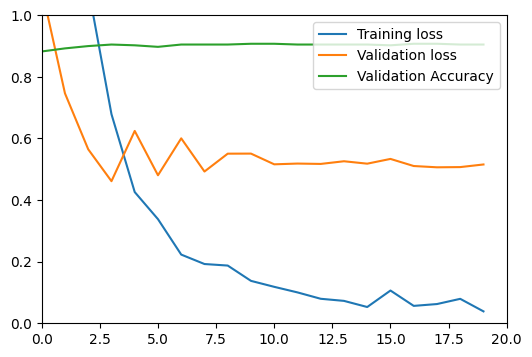

In [ ]:
set_seed(42)
teacher = CustomResNet50().to(device)
best_teacher_state_dict = torch.load('/content/drive/MyDrive/VietAI_CV02/resnet.pth')
teacher.load_state_dict(best_teacher_state_dict)

student = CustomResNet18().to(device)
save_path = ('../drive/MyDrive/VietAI_CV02/distilled_resnet18.pth')

os.chdir('/content/polyp_dataset_project10')
student_optimizer = optimizer_adam(student)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, mode='min', factor=0.1, patience=5)
distilled_knowledge_training(teacher, student , save_path, cfg["MAX_EPOCHS"], train_dataloader, val_dataloader, student_optimizer, loss_criteria, lr_scheduler, device)

In [ ]:
student_test = CustomResNet18().to(device)
student_test.load_state_dict(torch.load('/content/drive/MyDrive/VietAI_CV02/distilled_resnet18.pth'))
print(f'Testing Accuracy on class 0 of raw ResNet18: {testing_phase_single_class(raw_resnet18, test_dataloader, target_class_idx=0):.4f}%' )
print(f'Testing Accuracy on class 0 of student ResNet18: {testing_phase_single_class(student_test, test_dataloader, target_class_idx=0):.4f}%')

print(f'Testing Accuracy on class 1 of raw ResNet18: {testing_phase_single_class(raw_resnet18, test_dataloader, target_class_idx=1):.4f}%' )
print(f'Testing Accuracy on class 1 of student ResNet18: {testing_phase_single_class(student_test, test_dataloader, target_class_idx=1):.4f}%')

print(f'Testing Accuracy of raw ResNet18: {testing_phase(raw_resnet18, test_dataloader):.4f}%' )
print(f'Testing Accuracy of student ResNet18: {testing_phase(student_test, test_dataloader):.4f}%')

Testing Accuracy on class 0 of raw ResNet18: 0.3095%
Testing Accuracy on class 0 of student ResNet18: 0.3810%
Testing Accuracy on class 1 of raw ResNet18: 0.9749%
Testing Accuracy on class 1 of student ResNet18: 0.9860%
Testing Accuracy of raw ResNet18: 0.9050%
Testing Accuracy of student ResNet18: 0.9225%


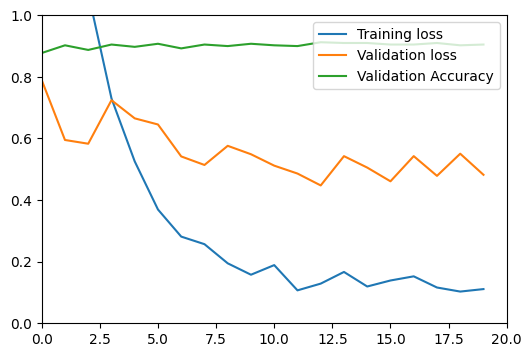

In [ ]:
set_seed(42)
student_mobile = CustomMobileNet().to(device)
save_path = ('../drive/MyDrive/VietAI_CV02/distilled_mobilenet.pth')

os.chdir('/content/polyp_dataset_project10')
student_mobile_optimizer = optimizer_adam(student_mobile)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(student_mobile_optimizer, mode='min', factor=0.1, patience=5)
distilled_knowledge_training(teacher, student_mobile, save_path, cfg["MAX_EPOCHS"], train_dataloader, val_dataloader, student_mobile_optimizer, loss_criteria, lr_scheduler, device)

In [ ]:
student_mobilenet = CustomMobileNet().to(device)
student_mobilenet.load_state_dict(torch.load('/content/drive/MyDrive/VietAI_CV02/distilled_mobilenet.pth'))

raw_mobilenet = CustomMobileNet().to(device)
raw_mobilenet.load_state_dict(torch.load('/content/drive/MyDrive/VietAI_CV02/raw_mobilenet.pth'))


print(f'Testing Accuracy on class 0 of raw MobileNet {testing_phase_single_class(raw_mobilenet, test_dataloader, target_class_idx=0):.4f}%' )
print(f'Testing Accuracy on class 0 of student MobileNet: {testing_phase_single_class(student_mobilenet, test_dataloader, target_class_idx=0):.4f}%')

print(f'Testing Accuracy on class 1 of raw MobileNet: {testing_phase_single_class(raw_mobilenet, test_dataloader, target_class_idx=1):.4f}%' )
print(f'Testing Accuracy on class 1 of student MobileNet: {testing_phase_single_class(student_mobilenet, test_dataloader, target_class_idx=1):.4f}%')

print(f'Testing Accuracy of raw MobileNet: {testing_phase(raw_mobilenet, test_dataloader):.4f}%' )
print(f'Testing Accuracy of student MobileNet: {testing_phase(student_mobilenet, test_dataloader):.4f}%')

Testing Accuracy on class 0 of raw MobileNet 0.3571%
Testing Accuracy on class 0 of student MobileNet: 0.3333%
Testing Accuracy on class 1 of raw MobileNet: 0.9777%
Testing Accuracy on class 1 of student MobileNet: 0.9860%
Testing Accuracy of raw MobileNet: 0.9125%
Testing Accuracy of student MobileNet: 0.9175%
